In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [148]:
import numpy as np

import sys
sys.path.append('../scripts/')

from proj1_helpers import *
from implementations import *
from implementation_variants import *
from costs import *
from plots import *

SEED = 42
DATA_PATH = '/Users/tstadler/Documents/Studies/CS-433/labs/ex05/template/height_weight_genders.csv'

In [74]:
def load_data(data_path, sample_size=1000):
    """Load data and convert it to the metric system."""
    data = np.genfromtxt(data_path, delimiter=",", skip_header=1, usecols=[1, 2])

    height = data[:, 0]
    weight = data[:, 1]
    gender = np.genfromtxt(data_path, delimiter=",", skip_header=1, usecols=[0], 
                           converters={0: lambda x: 0 if b"Male" in x else 1})
    
    # Convert to metric system
    height *= 0.025
    weight *= 0.454
    
    # Cast into arrays
    y = gender
    x = np.c_[height.reshape(-1), weight.reshape(-1)]
    
    # Subsample
    num_observations = y.shape[0]
    random_permuted_indices = np.random.permutation(num_observations)
    y = y[random_permuted_indices]
    x = x[random_permuted_indices]
    y = y[:sample_size]
    x = x[:sample_size]
    
    x, mean_x, std_x = standardise(x)
    
    return y, x

In [64]:
def encode_data_lr(y,x):
    ty = y.copy()
    ty[ty == -1] = 0
    
    tx = np.c_[np.ones(len(y)), x]
    
    return ty, tx

In [69]:
def eval_model(y, x, w, thresh=0):
    y_pred = predict_labels(w, x, thresh)
    acc = get_accuracy(y_pred, y)
    
    return acc

In [75]:
y, x = load_data(DATA_PATH)

# Split into train and evaluation set
(x_train, y_train), (x_eval, y_eval) = train_eval_split(y, x, split_ratio=.7, seed=SEED)

# Least-Squares

In [77]:
# Get linear least-squares model
w_ls, mse_ls = least_squares(y_train, x_train)

acc_ls = eval_model(y_eval, x_eval, w_ls)
print(acc_ls)

0.9233333333333333


# Ridge Regression

Maximum test accuracy 0.937142857142857 with lambda 0.0002069138081114788
Training accuracy: 0.9371428571428572
Test accuracy: 0.9233333333333333


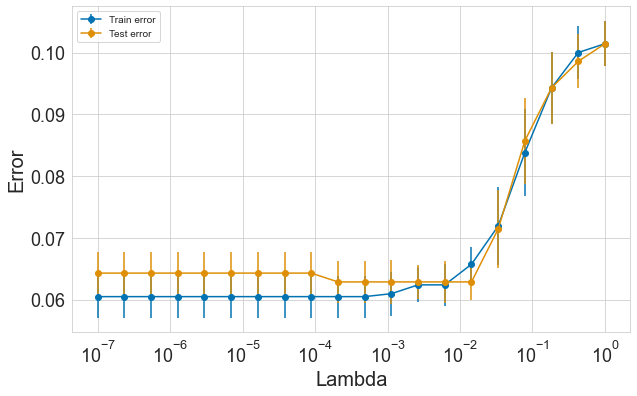

In [83]:
def test_ridge(lambdas, k_fold):
    
    # Hyperparameter optimisation
    acc_train = np.empty((len(lambdas), k_fold), float)
    acc_test = np.empty((len(lambdas), k_fold), float)

    for l, lambda_ in enumerate(lambdas):
        k = 0
        for train_split, test_split in k_fold_iter(y_train, x_train, k_fold):
            # Train
            w, loss = ridge_regression(train_split[1], train_split[0], lambda_)
            acc_tr = eval_model(train_split[1], train_split[0], w)
            acc_train[l, k] = acc_tr

            # Test
            acc_te = eval_model(test_split[1], test_split[0], w)
            acc_test[l, k] = acc_te

            k += 1
    fig = cross_validation_visualization(lambdas, 1-acc_train, 1-acc_test)

    avg_acc_test = np.mean(acc_test, axis=1)
    lambda_opt = lambdas[np.argmax(avg_acc_test)]

    print('Maximum test accuracy {} with lambda {}'.format(np.max(avg_acc_test), lambda_opt))
    
    # Run training
    w, loss = ridge_regression(y_train, x_train, lambda_opt)
    acc = eval_model(y_train, x_train, w)
    print(f'Training accuracy: {acc}')
    
    acc = eval_model(y_eval, x_eval, w)
    print(f'Test accuracy: {acc}')

lambdas = np.logspace(-7, 0, 20)
k_fold = 4

test_ridge(lambdas, k_fold)

# Logistic Regression

In [149]:
def test_logistic(gamma):
    
    max_iters = 10000
    
    ty_train, tx_train = encode_data_lr(y_train, x_train)
    w_initial = np.zeros(tx_train.shape[1])

    # Run gradient descent under MSE loss to find optimal weights
    w, loss = logistic_regression(ty_train, tx_train, w_initial, max_iters, gamma, verbose=True)
    acc_train = eval_model(y_train, tx_train, w, thresh=0.5)
    print(f'Training accuracy: {acc_train}')
    
    ty_eval, tx_eval = encode_data_lr(y_eval, x_eval)
    acc_test = eval_model(y_eval, tx_eval, w, thresh=0.5)
    print(f'Testing accuracy: {acc_test}')

test_logistic(0.001)

Gradient Descent (0/9999): loss=366.58613200362856, gradient=375.19973197071874
Gradient Descent (1000/9999): loss=105.98921826506555, gradient=2.164634114303125
Gradient Descent (2000/9999): loss=104.2254759013493, gradient=0.7009731995164035
Gradient Descent (3000/9999): loss=104.00843537338656, gradient=0.2723129891247057
Gradient Descent (4000/9999): loss=103.97395822862384, gradient=0.11219128089007935
Gradient Descent (5000/9999): loss=103.96798969699253, gradient=0.04728091942186007
Gradient Descent (6000/9999): loss=103.96692106718069, gradient=0.020111668197932784
Gradient Descent (7000/9999): loss=103.96672705641768, gradient=0.00858830879847749
Gradient Descent (8000/9999): loss=103.96669162640052, gradient=0.0036735724066869926
Gradient Descent (9000/9999): loss=103.96668514004641, gradient=0.0015724523867419078
Loss convergence:Terminate because loss did not change by more than threshold.
Training accuracy: 0.9428571428571428
Testing accuracy: 0.93


# Regularised Logistic Regression

Maximum test accuracy 0.9471428571428571 with lambda 1e-07
Gradient Descent (0/4999): loss=171.8317897308073, gradient=375.19973197071874
Gradient Descent (100/4999): loss=116.35800556955333, gradient=0.4327142604306331
Gradient Descent (200/4999): loss=115.72867452332864, gradient=0.017620494195404394
Gradient Descent (300/4999): loss=115.70349745787213, gradient=0.0007326358465216454
Gradient Descent (400/4999): loss=115.70245140127467, gradient=3.048805278423602e-05
Gradient Descent (500/4999): loss=115.7024078718037, gradient=1.2687809921119054e-06
Loss convergence:Terminate because loss did not change by more than threshold.
Training accuracy: 0.94
Test accuracy: 0.92


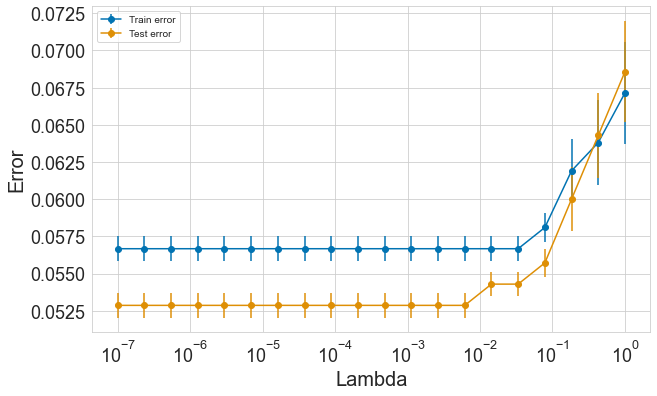

In [147]:
def test_logreg_reg(lambdas, k_fold, gamma):
    max_iters = 5000
    # Hyperparameter optimisation
    acc_train = np.empty((len(lambdas), k_fold), float)
    acc_test = np.empty((len(lambdas), k_fold), float)
    
    ty_train, tx_train = encode_data_lr(y_train, x_train)
    w_initial = np.zeros(tx_train.shape[1])
    
    for l, lambda_ in enumerate(lambdas):
        k = 0
        for train_split, test_split in k_fold_iter(ty_train, tx_train, k_fold):
            # Train
            w, loss = reg_logistic_regression(train_split[1], train_split[0], lambda_, 
                                          w_initial, max_iters, gamma, verbose=False)
            acc_tr = eval_model(train_split[1], train_split[0], w, thresh=0.5)
            acc_train[l, k] = acc_tr

            # Test
            acc_te = eval_model(test_split[1], test_split[0], w, thresh=0.5)
            acc_test[l, k] = acc_te

            k += 1
    fig = cross_validation_visualization(lambdas, 1-acc_train, 1-acc_test)

    avg_acc_test = np.mean(acc_test, axis=1)
    lambda_opt = lambdas[np.argmax(avg_acc_test)]

    print('Maximum test accuracy {} with lambda {}'.format(np.max(avg_acc_test), lambda_opt))
    
    # Run training
    w, loss = reg_logistic_regression(ty_train, tx_train, lambda_, 
                                          w_initial, max_iters, gamma, verbose=True)
    acc = eval_model(ty_train, tx_train, w)
    print(f'Training accuracy: {acc}')
    
    ty_eval, tx_eval = encode_data_lr(y_eval, x_eval)
    acc = eval_model(ty_eval, tx_eval, w)
    print(f'Test accuracy: {acc}')

lambdas = np.logspace(-7, 0, 20)
k_fold = 4

test_logreg_reg(lambdas, k_fold, gamma=0.01)